## Exploring *'tidyquant'* package

https://cran.r-project.org/web/packages/tidyquant/index.html

In [5]:
library(tidyquant)

Load the FANG data set.  
The FANG data set contains the historical stock prices for FB, AMZN, NFLX, and GOOG from the beginning of 2013 through the end of 2016.

In [4]:
data(FANG)
head(FANG)

symbol,date,open,high,low,close,volume,adjusted
FB,2013-01-02,27.44,28.18,27.42,28.00,69846400,28.00
FB,2013-01-03,27.88,28.47,27.59,27.77,63140600,27.77
FB,2013-01-04,28.01,28.93,27.83,28.76,72715400,28.76
FB,2013-01-07,28.69,29.79,28.65,29.42,83781800,29.42
FB,2013-01-08,29.51,29.60,28.86,29.06,45871300,29.06
FB,2013-01-09,29.67,30.60,29.49,30.59,104787700,30.59


### Core functions of *tidyquant*  

* Getting Financial Data from the web: **tq_get()**  
This is a one-stop shop for getting web-based financial data in a “tidy” data frame format.  
Get data for daily stock prices (historical), key statistics (real-time), key ratios (historical), financial statements, dividends, splits, economic data from the FRED, FOREX rates from Oanda.  


* Manipulating Financial Data: **tq_transmute()** and **tq_mutate()**  
Integration for many financial functions from xts, zoo, quantmod and TTR packages.  
tq_mutate() is used to add a column to the data frame, and tq_transmute() is used to return a new data frame which is necessary for periodicity changes.


* Coercing Data To and From xts and tibble: **as_tibble()** and **as_xts()**  
There are a ton of Stack Overflow articles on converting data frames to and from xts.  
These two functions can be used to answer 99% of these questions.


* Performance Analysis and Portfolio Analysis: **tq_performance()** and **tq_portfolio()**  
tq_performance() converts investment returns into performance metrics.  
tq_portfolio() aggregates a group (or multiple groups) of asset returns into one or more portfolios.

### Feature 1: PERFORMANCE ANALYTICS INTEGRATION
* Enables performance analysis of investment returns using a wide variety of metrics
* Enables portfolio aggregation, the process of aggregating a weighted group of stocks or investments into a single set of returns.

#### A : STOCK PERFORMANCE ANALYSIS
The Sharpe ratio is commonly used in finance as a measure of return per unit risk.  
The larger the value, the better the reward-to-risk trade off.

In [11]:
# tq_performance_fun_options()
args(tq_performance)
args(SharpeRatio)

function (data, Ra, Rb = NULL, performance_fun, ...) 
NULL

function (R, Rf = 0, p = 0.95, FUN = c("StdDev", "VaR", "ES"), 
    weights = NULL, annualize = FALSE, ...) 
NULL

For tq_performance:
- Ra = Asset returns  
- Rb = Baseline returns  

For SharpeRatio:
- R = Set of returns
- Rf = Risk free rate
- P = Confidence level

In [12]:
FANG %>%
    group_by(symbol) %>%
    tq_transmute(ohlc_fun   = Ad,
                 mutate_fun = periodReturn,
                 period     = "daily") %>%
    tq_performance(Ra              = daily.returns,
                   Rb              = NULL,
                   performance_fun = SharpeRatio,
                   Rf              = 0,
                   p               = 0.95,
                   FUN             = "StdDev")

symbol,"StdDevSharpe(Rf=0%,p=95%)"
FB,0.07439327
AMZN,0.06442433
NFLX,0.08402702
GOOG,0.05825002


#### B: BASIC PORTFOLIO PERFORMANCE

Combining a group of assets into a portfolio is one of the most useful techniques for controlling risk versus reward. The blending of assets naturally diversifies and can reduce downside risk.  
Further, portfolio attribution is a set of techniques used to analyze a portfolio or set of portfolios against a benchmark.

The process for a single portfolio aggregation without a benchmark is shown below.  
Portfolio aggregation requires a set of weights that can be applied to the various assets (stocks) in the portfolio.  
Our portfolio consists of FB, AMZN, NFLX, and GOOG. Passing the weights of 50%, 25%, 25%, and 0% blends and aggregates into one set of portfolio returns.

In [14]:
weights <- c(0.50, 0.25, 0.25, 0.00)
FANG_portfolio <- FANG %>% 
    group_by(symbol) %>%
    tq_transmute(ohlc_fun   = Ad,
                 mutate_fun = periodReturn,
                 period     = "monthly") %>%
    tq_portfolio(assets_col  = symbol,
                 returns_col = monthly.returns,
                 weights     = weights)

In [15]:
head(FANG_portfolio)

date,portfolio.returns
2013-01-31,0.260144557
2013-02-28,-0.004558003
2013-03-28,-0.019454685
2013-04-30,0.080958243
2013-05-31,-0.013883075
2013-06-28,-0.017906983


At this point, it’s nice to visualize using a wealth index, which shows the growth of the portfolio.  
The wealth index is actually an option in tq_portfolio, but it can also be created by converting the portfolio returns using the cumprod() function shown below.

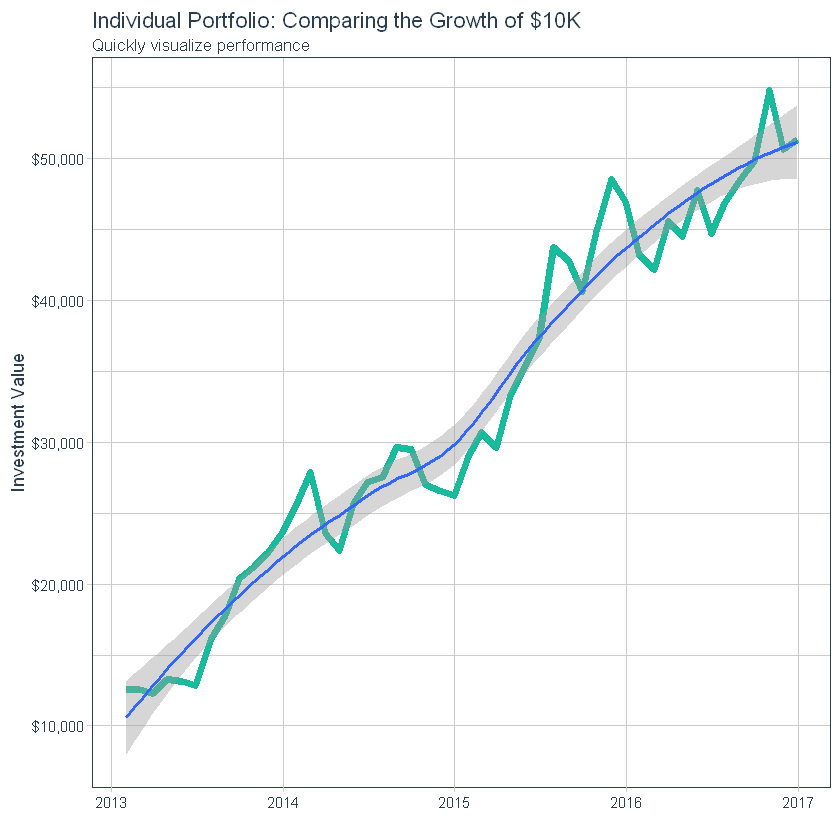

In [16]:
init.investment <- 10000
FANG_portfolio %>%
    mutate(wealth.index = init.investment * cumprod(1 + portfolio.returns)) %>%
    ggplot(aes(x = date, y = wealth.index)) +
    geom_line(size = 2, color = palette_light()[[3]]) +
    geom_smooth(method = "loess") +
    labs(title = "Individual Portfolio: Comparing the Growth of $10K",
         subtitle = "Quickly visualize performance",
         x = "", y = "Investment Value") +
    theme_tq() +
    scale_y_continuous(labels = scales::dollar)

We can get some performance metrics using PerformanceAnalytics functions.  
The table functions are the most useful since they calculate groups of portfolio attribution metrics.  
The table.Stats function returns a “tidy” set of 15 summary statistics on the stock returns including arithmetic mean, standard deviation, skewness, kurtosis, and more.

For more examples, go to - https://cran.r-project.org/web/packages/tidyquant/vignettes/TQ05-performance-analysis-with-tidyquant.html

In [17]:
FANG_portfolio %>%
    tq_performance(Ra = portfolio.returns,
                   Rb = NULL,
                   performance_fun = table.Stats)

ArithmeticMean,GeometricMean,Kurtosis,LCLMean(0.95),Maximum,Median,Minimum,NAs,Observations,Quartile1,Quartile3,SEMean,Skewness,Stdev,UCLMean(0.95),Variance
0.0379,0.0347,0.5327,0.0138,0.2601,0.042,-0.153,0,48,-0.0198,0.0808,0.0119,0.4423,0.0827,0.0619,0.0068


### Feature 2: NEW ggplot THEMES

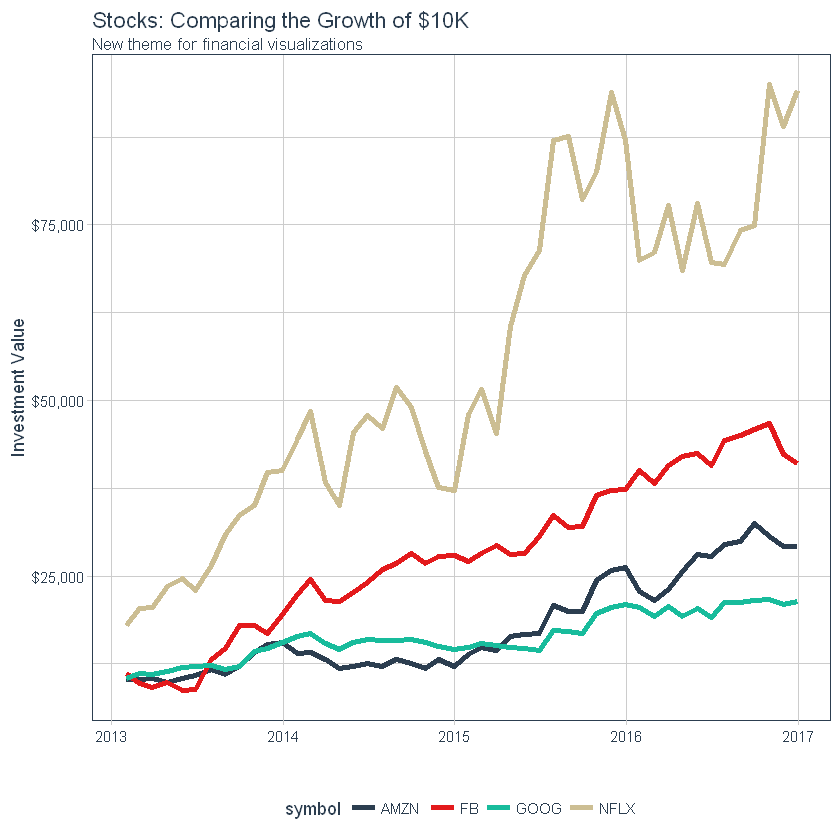

In [18]:
FANG %>%
    group_by(symbol) %>%
    tq_transmute(ohlc_fun   = Ad,
                 mutate_fun = periodReturn,
                 period     = "monthly") %>%
    mutate(wealth.index = 10000 * cumprod(1 + monthly.returns)) %>%
    ggplot(aes(x = date, y = wealth.index, color = symbol)) +
    geom_line(size = 1.5) +
    labs(title = "Stocks: Comparing the Growth of $10K",
         subtitle = "New theme for financial visualizations",
         x = "", y = "Investment Value") +
    scale_y_continuous(labels = scales::dollar) +
    theme_tq() +
    scale_color_tq(theme = "light")

### Feature 3: “COMPOUND GETTERS” IN TQ_GET
Compound getters are a nice tool to get multiple data sets for one stock symbol.  
For example, one may want the “key.ratios” and the “key.stats”, which provides key fundamental and financial ratio data on both a historical and real-time basis, respectively. 

In [21]:
AAPL_data <- tq_get("AAPL", get = c("key.ratios", "key.stats"))

In [24]:
summary(AAPL_data)

    symbol          key.ratios.Length  key.ratios.Class  key.ratios.Mode
 Length:1           2       tbl_df  list                                
 Class :character                                                       
 Mode  :character                                                       
 key.stats.Length  key.stats.Class  key.stats.Mode
 55      tbl_df  list                             
                                                  
                                                  

In [25]:
AAPL_data %>% unnest(key.ratios) 

symbol,section,data


In [28]:
AAPL_data %>% 
    unnest(key.ratios) %>% 
    unnest(data)

symbol,section,sub.section,group,category,date,value
AAPL,Financials,Financials,1,Revenue USD Mil,2007-09-01,24578.0
AAPL,Financials,Financials,1,Revenue USD Mil,2008-09-01,37491.0
AAPL,Financials,Financials,1,Revenue USD Mil,2009-09-01,42905.0
AAPL,Financials,Financials,1,Revenue USD Mil,2010-09-01,65225.0
AAPL,Financials,Financials,1,Revenue USD Mil,2011-09-01,108249.0
AAPL,Financials,Financials,1,Revenue USD Mil,2012-09-01,156508.0
AAPL,Financials,Financials,1,Revenue USD Mil,2013-09-01,170910.0
AAPL,Financials,Financials,1,Revenue USD Mil,2014-09-01,182795.0
AAPL,Financials,Financials,1,Revenue USD Mil,2015-09-01,233715.0
AAPL,Financials,Financials,1,Revenue USD Mil,2016-09-01,215639.0


In [29]:
AAPL_data %>% unnest(key.stats, .drop = TRUE)


symbol,Ask,Ask.Size,Average.Daily.Volume,Bid,Bid.Size,Book.Value,Change,Change.From.200.day.Moving.Average,Change.From.50.day.Moving.Average,...,Price.to.EPS.Estimate.Current.Year,Price.to.EPS.Estimate.Next.Year,Price.to.Sales,Range.52.week,Revenue,Shares.Outstanding,Short.Ratio,Stock.Exchange,Target.Price.1.yr.,Volume
AAPL,139.13,500,28104300,139.08,100,25.19,0.46,21.25,7.04,...,15.56,13.71,3.34,89.47 - 140.28,2.1812e+11,5246540000,1.45,NMS,142.69,19612801


### Feature 4: TQ_INDEX AND TQ_EXCHANGE

tq_index("SP500") %>%
    tq_get(get = "stock.prices")

tq_exchange("NASDAQ") %>%
    tq_get(get = "stock.prices")

In [ ]:
tq_exchange_options()

In [ ]:
tq_index_options()